## Sleep analysis, using Passive Infrared (PIR) data, in 10sec bins from a single central PIR, at 200-220mm above the cage floor.  Previously EEG-telemetered animals allow direct comparison of sleep scored by direct and non-invasive methods. 

### 1st setup analysis environment:

In [1]:
import numpy as np  # calculations
import pandas as pd  # dataframes and IO
import matplotlib.pyplot as plt  # plotting
# show graphs/figures in notebooks
%matplotlib inline

import seaborn as sns  # statistical plots and analysis
sns.set(style="ticks")   # styling
sns.set_context("poster")

### Then import .CSV text file from activity monitoring (with ISO-8601 encoding for the timepoints)

In [2]:
PIR = pd.read_csv('../PIRdata/1sensorPIRvsEEGdata.csv',parse_dates=[0],index_col='Time')

In [3]:
PIR.head()

,PIR1,PIR2,PIR3,PIR4,PIR5,PIR6,LDR
Time,,,,,,,
2014-03-17 18:56:28.647000+00:00,0,0,0,100,0,0,732
2014-03-17 18:56:38.665000+00:00,16,0,0,0,0,0,733
2014-03-17 18:56:48.679000+00:00,2,0,42,0,3,0,732
2014-03-17 18:56:58.697000+00:00,0,0,7,0,0,0,733
2014-03-17 18:57:08.711000+00:00,0,0,0,0,0,0,733


In [4]:
PIR.pop('PIR4') # remove channels with no Telemetered mice / no sensor
PIR.pop('PIR6')
PIR.columns=('Act_A', 'Act_B','Act_C', 'Act_D', 'Light') # and rename the remaining columns with activity data
#PIR.plot(subplots=True, figsize=(16,12))

### next identify time of lights ON (to match start of scored EEG data)

<AxesSubplot: xlabel='Time'>

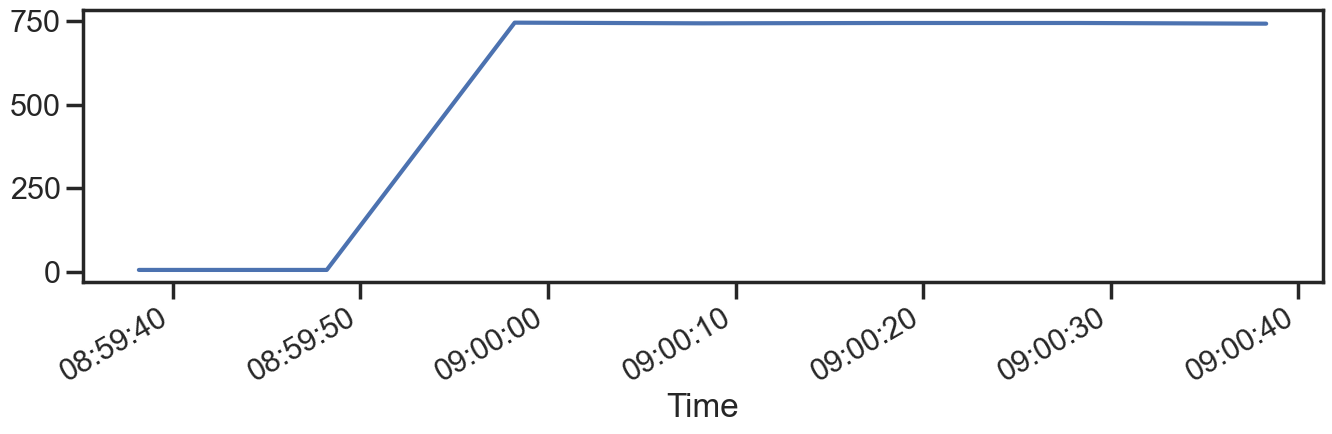

In [5]:
PIR['Light']['2014-03-18 08:59:30': '2014-03-18 09:00:40'].plot(figsize =(16,4))

### Define period to match EEG data

C:\Users\loz_r\AppData\Local\Temp\ipykernel_25360\377985149.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  PIR_24 = PIR.truncate(before='2014-03-18 09:00:00', after='2014-03-19 09:00:00')


array([<AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>], dtype=object)

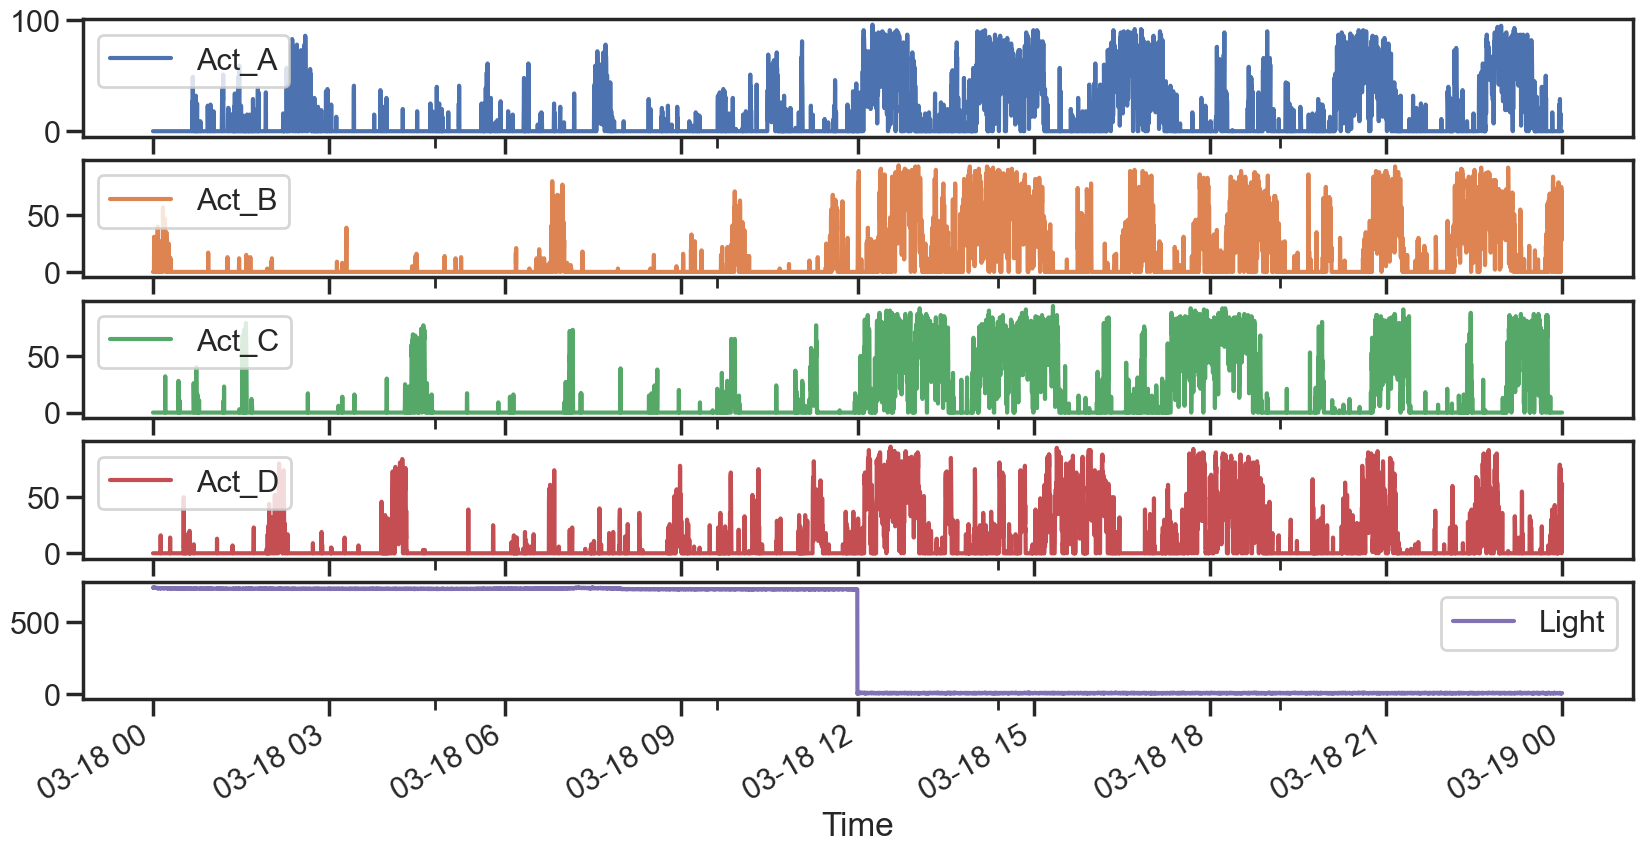

In [6]:
PIR_24 = PIR.truncate(before='2014-03-18 09:00:00', after='2014-03-19 09:00:00')
PIR_24shift = PIR_24.shift(-9, freq='H')# move data on timescale so 0 represents 'lights on'
PIR_24shift.plot(subplots=True,figsize=(20,10))


### Define sleepscan function and run with selected data 

In [7]:
# run through trace looking for bouts of sleep (defined as 4 or more sequential '0' values) variable 'a' is dataframe of PIR data

def sleepscan(a,bins):
    ss = a.rolling(bins).sum()
    y = ss==0
    return y.astype(int)   # if numerical output is required

In [8]:
# for each column of activity data define PIR-derived sleep as a new column
ss = PIR_24shift.assign(PIR_A =sleepscan(PIR_24shift['Act_A'],4),  
                       PIR_B =sleepscan(PIR_24shift['Act_B'],4),
                        PIR_C =sleepscan(PIR_24shift['Act_C'],4),
                         PIR_D =sleepscan(PIR_24shift['Act_D'],4)).resample('10S').mean()
                
ss.head() # show top of new dataframe

,Act_A,Act_B,Act_C,Act_D,Light,PIR_A,PIR_B,PIR_C,PIR_D
Time,,,,,,,,,
2014-03-18 00:00:00+00:00,0.0,0.0,0.0,0.0,743.0,0.0,0.0,0.0,0.0
2014-03-18 00:00:10+00:00,0.0,0.0,0.0,0.0,744.0,0.0,0.0,0.0,0.0
2014-03-18 00:00:20+00:00,0.0,0.0,0.0,0.0,744.0,0.0,0.0,0.0,0.0
2014-03-18 00:00:30+00:00,0.0,0.0,0.0,0.0,742.0,1.0,1.0,1.0,1.0
2014-03-18 00:00:40+00:00,0.0,0.0,0.0,0.0,743.0,1.0,1.0,1.0,1.0


### Importing EEG data scored by Sibah Hasan  (follow correction for channels A and B on EEG recordings)

#### Scored as 10 second bins starting at 9am (lights on) , for clarity we will only import the columns for total sleep, although REM and NREM sleep were scored)

In [9]:
eeg10S = pd.read_csv('../PIRdata/EEG_4mice10sec.csv',index_col=False, 
                     usecols=['MouseA Total sleep ','MouseB Total sleep ','MouseC Total sleep ','MouseD Total sleep '])
eeg10S.columns=('EEG_A', 'EEG_B', 'EEG_C','EEG_D') # rename columns
eeg10S.head()

,EEG_A,EEG_B,EEG_C,EEG_D
0,0,0,1,0
1,1,0,1,0
2,1,0,1,1
3,1,0,1,1
4,1,0,1,1


In [10]:
ss.reset_index(inplace=True) # use sequential numbered index to allow concatination (joining) of data
ss_all = pd.concat([ss,eeg10S], axis=1) # join data
ss_all.set_index('Time',inplace=True) # Time as index

ss_all.head()

,Act_A,Act_B,Act_C,Act_D,Light,PIR_A,PIR_B,PIR_C,PIR_D,EEG_A,EEG_B,EEG_C,EEG_D
Time,,,,,,,,,,,,,
2014-03-18 00:00:00+00:00,0.0,0.0,0.0,0.0,743.0,0.0,0.0,0.0,0.0,0,0,1,0
2014-03-18 00:00:10+00:00,0.0,0.0,0.0,0.0,744.0,0.0,0.0,0.0,0.0,1,0,1,0
2014-03-18 00:00:20+00:00,0.0,0.0,0.0,0.0,744.0,0.0,0.0,0.0,0.0,1,0,1,1
2014-03-18 00:00:30+00:00,0.0,0.0,0.0,0.0,742.0,1.0,1.0,1.0,1.0,1,0,1,1
2014-03-18 00:00:40+00:00,0.0,0.0,0.0,0.0,743.0,1.0,1.0,1.0,1.0,1,0,1,1


In [11]:
#ss_all.pop('index') # and drop old index
ss_all.head()

,Act_A,Act_B,Act_C,Act_D,Light,PIR_A,PIR_B,PIR_C,PIR_D,EEG_A,EEG_B,EEG_C,EEG_D
Time,,,,,,,,,,,,,
2014-03-18 00:00:00+00:00,0.0,0.0,0.0,0.0,743.0,0.0,0.0,0.0,0.0,0,0,1,0
2014-03-18 00:00:10+00:00,0.0,0.0,0.0,0.0,744.0,0.0,0.0,0.0,0.0,1,0,1,0
2014-03-18 00:00:20+00:00,0.0,0.0,0.0,0.0,744.0,0.0,0.0,0.0,0.0,1,0,1,1
2014-03-18 00:00:30+00:00,0.0,0.0,0.0,0.0,742.0,1.0,1.0,1.0,1.0,1,0,1,1
2014-03-18 00:00:40+00:00,0.0,0.0,0.0,0.0,743.0,1.0,1.0,1.0,1.0,1,0,1,1


### Then resample as an average of 30min to get proportion sleep (scored from immobility) 

In [12]:
EEG30 = ss_all.resample('30T').mean() 
EEG30.tail()

,Act_A,Act_B,Act_C,Act_D,Light,PIR_A,PIR_B,PIR_C,PIR_D,EEG_A,EEG_B,EEG_C,EEG_D
Time,,,,,,,,,,,,,
2014-03-18 21:30:00+00:00,0.860335,1.726257,0.139665,0.553073,6.307263,0.860335,0.782123,0.955307,0.899441,0.911111,0.827778,0.900000,0.933333
2014-03-18 22:00:00+00:00,7.022222,37.494444,5.938889,3.555556,6.233333,0.550000,0.088889,0.588889,0.627778,0.488889,0.033333,0.505556,0.622222
2014-03-18 22:30:00+00:00,44.361111,51.711111,0.244444,28.938889,6.300000,0.155556,0.011111,0.933333,0.166667,0.138889,0.000000,0.805556,0.011111
2014-03-18 23:00:00+00:00,57.659218,17.117318,50.402235,2.581006,6.268156,0.000000,0.391061,0.061453,0.787709,0.000000,0.266667,0.000000,0.838889
2014-03-18 23:30:00+00:00,4.122222,22.005556,24.594444,7.983333,6.122222,0.638889,0.366667,0.438889,0.594444,0.672222,0.372222,0.283333,0.577778


<AxesSubplot: xlabel='Time'>

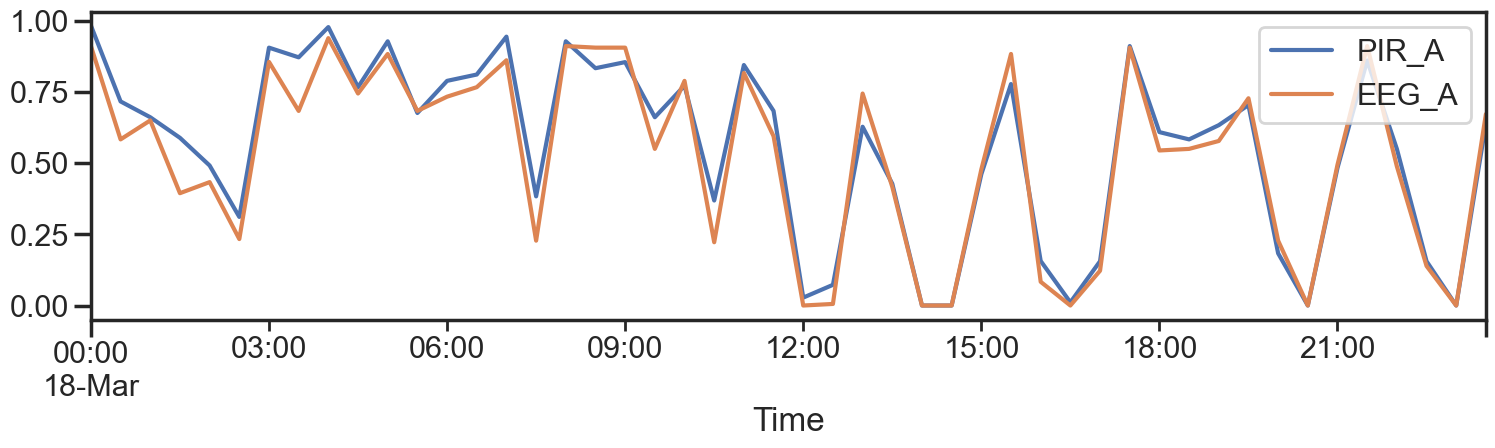

In [13]:
EEG30.loc[:,['PIR_A','EEG_A']].plot(figsize=(18,4)) # show data for one mouse 

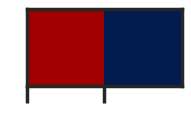

In [14]:
# red #A10000  and blue #011C4E colour pallette for figure2

EEGred = ["#A10000", "#011C4E"]  

sns.palplot(sns.color_palette(EEGred)) # show colours


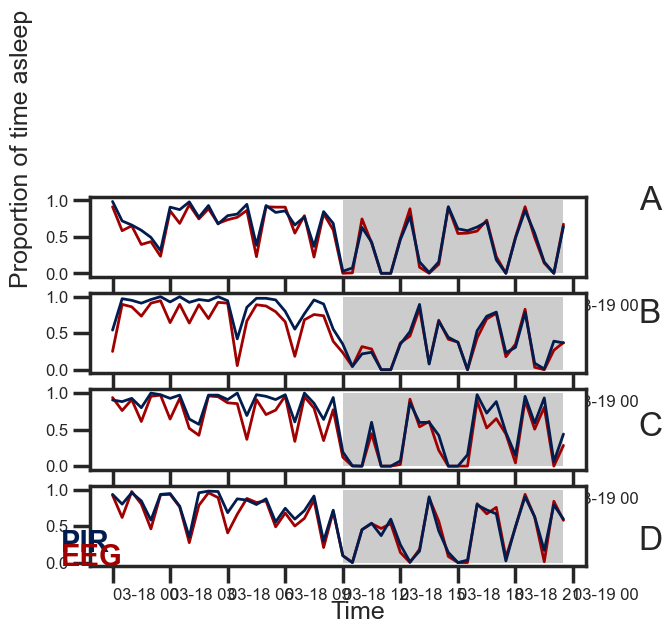

In [15]:
sns.set_palette(EEGred)
sns.set_context("poster", font_scale=1.2)

fig, (ax1,ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1)
fig.text(1, 0.87,'A',fontsize=24, horizontalalignment='center',verticalalignment='center')
fig.text(1, 0.635,'B',fontsize=24, horizontalalignment='center',verticalalignment='center')
fig.text(1, 0.4,'C',fontsize=24, horizontalalignment='center',verticalalignment='center')
fig.text(1, 0.162,'D',fontsize=24, horizontalalignment='center',verticalalignment='center')
fig.text(0,0.7, 'Proportion of time asleep', fontsize=18, rotation='vertical')
fig.text(0.5,0,'Time', fontsize=18)
fig.text(0.08,0.14,'PIR', fontsize=21, color="#011C4E", fontweight='semibold')
fig.text(0.08,0.11,'EEG', fontsize=21, color="#A10000", fontweight='semibold')

plt.subplot(411)
plt.plot(EEG30.index, EEG30['EEG_A'], label= "EEG total sleep",lw=2)
plt.fill_between(EEG30.index, 0, 1, where=EEG30.index>='2014-03-18 12:00:00',lw=0, alpha=0.6, facecolor='#aaaaaa')
plt.plot(EEG30.index, EEG30['PIR_A'],label= "PIR sleep", lw=2)
plt.xticks(horizontalalignment='left',fontsize=12)
plt.yticks([0,0.5,1],fontsize=12)


plt.subplot(412)
plt.plot(EEG30.index, EEG30['EEG_B'], lw=2)
plt.plot(EEG30.index, EEG30['PIR_B'], lw=2)
plt.fill_between(EEG30.index, 0, 1, where=EEG30.index>='2014-03-18 12:00:00',lw=0, alpha=0.6, facecolor='#aaaaaa')
plt.xticks(horizontalalignment='left',fontsize=12)
plt.yticks([0,0.5,1],fontsize=12)

plt.subplot(413)
plt.plot(EEG30.index, EEG30['EEG_C'], lw=2)
plt.plot(EEG30.index, EEG30['PIR_C'], lw=2)
plt.fill_between(EEG30.index, 0, 1, where=EEG30.index>='2014-03-18 12:00:00',lw=0, alpha=0.6, facecolor='#aaaaaa')
plt.xticks(horizontalalignment='left',fontsize=12)
plt.yticks([0,0.5,1],fontsize=12)

plt.subplot(414)
plt.plot(EEG30.index, EEG30['EEG_D'], lw=2)
plt.plot(EEG30.index, EEG30['PIR_D'], lw=2)
plt.fill_between(EEG30.index, 0, 1, where=EEG30.index>='2014-03-18 12:00:00',lw=0, alpha=0.6, facecolor='#aaaaaa')
plt.xticks(horizontalalignment='left',fontsize=12)
plt.yticks([0,0.5,1],fontsize=12)


plt.show() #tight_layout(h_pad=0.1,pad=0.1)

# options for saving figures
#plt.savefig('correlations_BlueRed.eps',format='eps', dpi=1200, bbox_inches='tight', pad_inches=0.5) 
#plt.savefig('correlations_BlueRed.jpg',format='jpg', dpi=600,frameon=2, bbox_inches='tight', pad_inches=0.5)

plt.show()

In [16]:
sns.set_style("white")
sns.set_context("talk", font_scale=1.2)
corr30 = EEG30
corr30.pop('Light')
#corr30.pop('index')
corr30.corr()


KeyError: 'index'

TypeError: FigureCanvasPS._print_figure() got an unexpected keyword argument 'frameon'

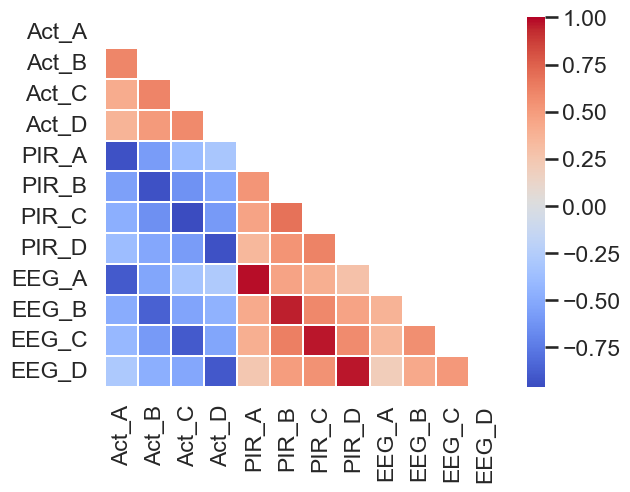

In [17]:
corr = corr30.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set_context("talk")
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=False, linewidths=0.1, cmap='coolwarm')
    
plt.savefig('../Figures/1week.htmlCorrFig3py3.eps',format='eps',
            dpi=600,pad_inches=2, frameon=False)

# Bland-Altman as an alternative to correlation plots?

### Combined data from all 4 mice (paired estimates of sleep by PIR and EEG aligned in Excel)

In [22]:
df = pd.read_csv('../PIRdata/blandAltLandD.csv')

In [23]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axis([0, 30, -30, 30])
    plt.axhline(md,    linestyle='-', *args, **kwargs)
    plt.axhline(md + 1.96*sd,  linestyle='--', *args, **kwargs)
    plt.axhline(md - 1.96*sd,  linestyle='--', *args, **kwargs)
    

In [24]:
def bland_altman_output(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    return md , md-(1.96*sd), md+(1.96*sd)

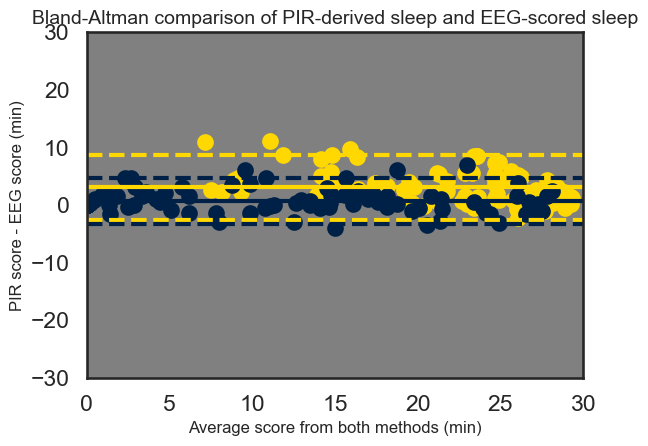

In [25]:
sns.set_context('talk')
c1, c2, c3 = sns.blend_palette(["#002147","gold","grey"], 3)
plt.subplot(111, facecolor=c3)

bland_altman_plot(df.PIR_Light, df.EEG_Light,color=c2, linewidth=3)
bland_altman_plot(df.PIR_dark, df.EEG_dark,color=c1, linewidth=3)
plt.xlabel('Average score from both methods (min)', fontsize=12)
plt.ylabel('PIR score - EEG score (min)', fontsize=12)

plt.title('Bland-Altman comparison of PIR-derived sleep and EEG-scored sleep', fontsize=14)

plt.savefig('../Figures/blandAltman4mice.png',format='png', dpi=1200,pad_inches=0.2)
plt.tight_layout()

In [26]:
bland_altman_output(df.PIR_Light, df.EEG_Light)

(3.0759057215625005, -2.565385707369178, 8.71719715049418)

In [27]:
bland_altman_output(df.PIR_dark, df.EEG_dark)

(0.6970580275000001, -3.2774109100679802, 4.67152696506798)

In [28]:
# Combine (concatenate) these data to get overall comparison of measurements

df.PIR = pd.concat([df.PIR_dark, df.PIR_Light],axis=0)
df.EEG = pd.concat([df.EEG_dark, df.EEG_Light],axis=0)
dfall =pd.concat([df.PIR, df.EEG], axis=1, keys=['PIR', 'EEG'])
dfall.head()

C:\Users\loz_r\AppData\Local\Temp\ipykernel_25360\423792357.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.PIR = pd.concat([df.PIR_dark, df.PIR_Light],axis=0)
C:\Users\loz_r\AppData\Local\Temp\ipykernel_25360\423792357.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.EEG = pd.concat([df.EEG_dark, df.EEG_Light],axis=0)


,PIR,EEG
0,0.833333,0.00
1,2.166667,0.17
2,18.833333,22.33
3,12.833333,12.50
4,0.000000,0.00


In [29]:
bland_altman_output(dfall.PIR, dfall.EEG) # mean and 95% CIs for overall comparison

(1.8864818745312502, -3.521392885939874, 7.294356635002374)